In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import torch.nn.functional as F

In [133]:
import torch.nn as nn
import torch.utils.data.dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from losses import compute_contrastive_loss_from_feats
from utils import *  # bad practice, nvm
from models import *

ckpt_dir = 'exp_data'

In [134]:
from dataset import ImageDataset
from training_config import doodles, reals, doodle_size, real_size, NUM_CLASSES

train_set = ImageDataset(doodles, reals, doodle_size, real_size, train=True)
val_set = ImageDataset(doodles, reals, doodle_size, real_size, train=False)

Train = True. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 7022, real data size 46364, ratio 0.15145371408851696
Train = False. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 1764, real data size 9341, ratio 0.18884487742211756


In [135]:
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=True)

In [136]:
doodle_model = DoodleMLP(doodle_size * doodle_size, 128, NUM_CLASSES, dropout=0.2)
real_model = RealMLP(real_size * real_size * 3, 512, NUM_CLASSES, dropout=0.2)

In [137]:
model1 = load_model_dic(doodle_model, "mlp_trained/14_model1.pt")
model2 = load_model_dic(real_model, "mlp_trained/14_model2.pt")

Model loaded: mlp_trained/14_model1.pt
Model loaded: mlp_trained/14_model2.pt


In [152]:
train_dataset = ImageDataset(doodles, reals, 64, 64, train=True)
val_dataset = ImageDataset(doodles, reals, 64, 64, train=False)
dt = train_dataset.doodle_preprocess
rt = train_dataset.real_preprocess
model1.eval()
model2.eval()

Train = True. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 7022, real data size 46364, ratio 0.15145371408851696
Train = False. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 1764, real data size 9341, ratio 0.18884487742211756


RealMLP(
  (l1): Linear(in_features=12288, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=512, bias=True)
  (l3): Linear(in_features=512, out_features=512, bias=True)
  (l4): Linear(in_features=512, out_features=9, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [190]:
X1, Y1, X2, Y2 = (val_dataset.doodle_data,
                  val_dataset.doodle_label,
                  val_dataset.real_data,
                  val_dataset.real_label)

In [226]:
preds1 = []
preds2 = []
for x1, y1 in zip(X1, Y1):
    preds1.append(model1(dt(x1)))
for x2, y2 in zip(X2, Y2):
    preds2.append(model2(torch.unsqueeze(rt(x2), axis=0)))
preds1 = torch.cat(preds1)
preds2 = torch.cat(preds2)

print(compute_accuracy(preds1, torch.Tensor(Y1)))
print(compute_accuracy(preds2, torch.Tensor(Y2)))

0.29705215419501135
0.5162188202547907


In [238]:
_, yhat1 = torch.max(preds1, 1)
_, yhat2 = torch.max(preds2, 1)

correct_idx1 = np.where(yhat1.numpy() == Y1)[0]
correct_idx2 = np.where(yhat2.numpy() == Y2)[0]
wrong_idx1 = np.where(yhat1.numpy() != Y1)[0]
wrong_idx2 = np.where(yhat2.numpy() != Y2)[0]

In [251]:
def plot_sample(imgs, title, n=10):
    fig, ax = plt.subplots(1, n)
    fig.suptitle(title)
    plt.gcf().set_size_inches(2*n, 2)
    imgs = imgs[np.random.choice(len(imgs), n)]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap='gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.show()

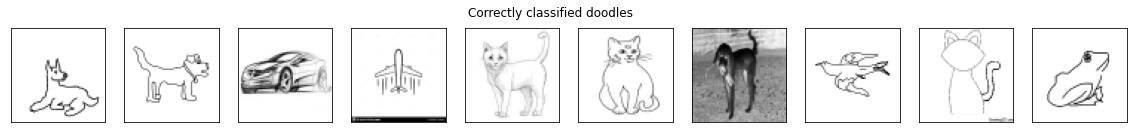

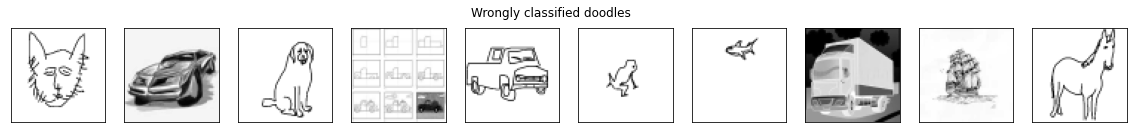

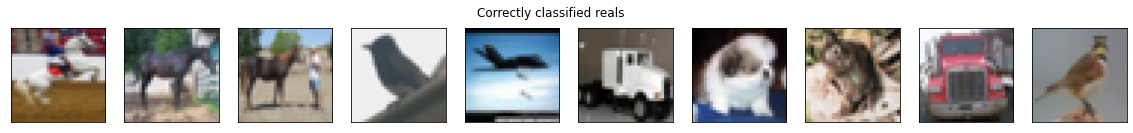

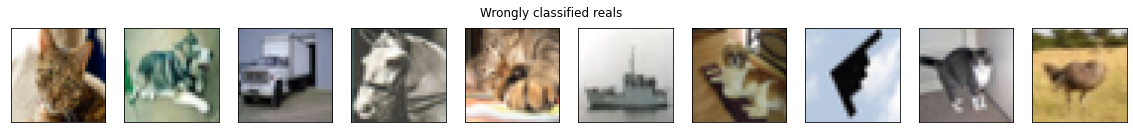

In [254]:
plot_sample(X1[correct_idx1], "Correctly classified doodles", n=10)
plot_sample(X1[wrong_idx1], "Wrongly classified doodles", n=10)
plot_sample(X2[correct_idx2], "Correctly classified reals", n=10)
plot_sample(X2[wrong_idx2], "Wrongly classified reals", n=10)

# Class-Level Accuracy

In [ ]:
nb_classes = 9
confusion_matrix1 = torch.zeros(nb_classes, nb_classes)

In [222]:
nb_classes = 9
confusion_matrix1 = torch.zeros(nb_classes, nb_classes)
for x1, y1 in zip(X1, Y1):
    yhat1 = model1(dt(x1))
    _, yhat1 = torch.max(yhat1, 1)
    confusion_matrix1[y1, yhat1] += 1
print(confusion_matrix1.diag()/confusion_matrix1.sum(1))

tensor([0.2919, 0.3116, 0.2275, 0.2714, 0.2806, 0.3756, 0.2727, 0.3413, 0.3011])


In [221]:
nb_classes = 9
confusion_matrix2 = torch.zeros(nb_classes, nb_classes)
for x2, y2 in zip(X2, Y2):
    yhat2 = model2(torch.unsqueeze(rt(x2), axis=0))
    _, yhat2 = torch.max(yhat2, 1)
    confusion_matrix2[y2, yhat2] += 1
print(confusion_matrix2.diag()/confusion_matrix2.sum(1))

tensor([0.6302, 0.1202, 0.3740, 0.4529, 0.6413, 0.6500, 0.5894, 0.5096, 0.6814])


# Visualise T-SNE Embeddings

In [ ]:
def plot_tsne(d, title="", alpha=1, size=1):
    class_to_idx = {clas: idx for idx, clas in enumerate(d.keys())}
    idx_to_class = {idx: clas for idx, clas in enumerate(d.keys())}
    
    labels = []
    for clas, data in d.items():
        labels += [class_to_idx[clas]] * data.shape[0]
    labels = np.asarray(labels)
    
    data = np.concatenate(list(d.values()))
    data = data.reshape((data.shape[0], -1))
    pc = PCA(n_components=50).fit_transform(data)
    
    c = TSNE(n_components=2).fit_transform(pc)
    
    colors = cm.rainbow(np.linspace(0, 1, len(d.keys())))
    plt.title(title)
    for clas, color in zip(d.keys(), colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

In [ ]:
xs1 = []
xs2 = []
fs1 = []
fs2 = []
ys1 = []
ys2 = []
with torch.no_grad():
    for i, (x1, y1, x2, y2) in enumerate(val_loader):
        pred1, feats1 = model1(x1, return_feats=True)
        pred2, feats2 = model2(x2, return_feats=True)
        xs1.append(x1)
        xs2.append(x2)
        fs1.append(feats1)
        fs2.append(feats2)
        ys1.append(y1)
        ys2.append(y2)
data1 = torch.cat(xs1).numpy()
data2 = torch.cat(xs2).numpy()
feats1 = torch.cat(fs1).numpy()
labels1 = torch.cat(ys1).numpy()
feats2 = torch.cat(fs2).numpy()
labels2 = torch.cat(ys2).numpy()

In [ ]:
def plot_tsne(feats, labels, pc=0, size=1, alpha=1):
    if pc > 0:
        feats = PCA(n_components=pc).fit_transform(feats)
    c = TSNE(n_components=2).fit_transform(feats)
    CLASSES = ["airplane", "car", "bird", "cat", "dog", "frog", "horse", "ship", "truck"]
    class_to_idx = {k: i for i, k in enumerate(CLASSES)}
    colors = cm.rainbow(np.linspace(0, 1, len(CLASSES)))
    plt.title("TSNE of MLP embeddings")
    for clas, color in zip(CLASSES, colors):
        idx = np.where(labels == class_to_idx[clas])[0]
        plt.scatter(c[idx][:,0], c[idx][:,1], label=clas, s=size, alpha=alpha, color=color)
    plt.legend(loc='best', markerscale=2)
    plt.show()

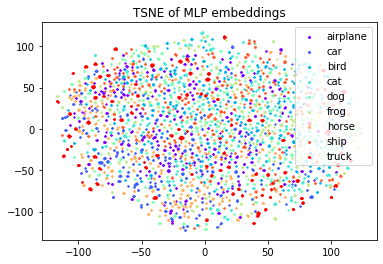

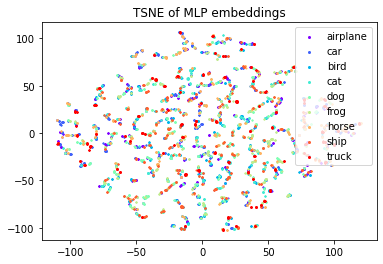

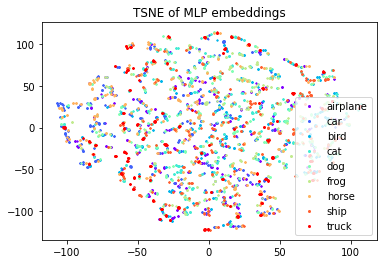

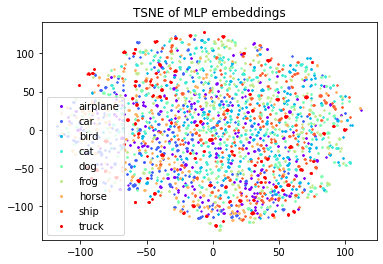

In [124]:
plot_tsne(feats1, labels1, pc=0)
plot_tsne(feats1, labels1, pc=2)
plot_tsne(feats1, labels1, pc=3)
plot_tsne(feats1, labels1, pc=10)

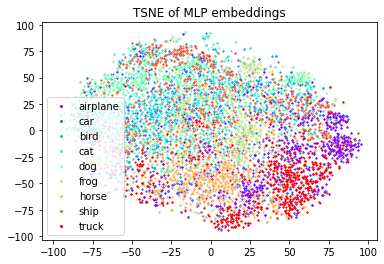

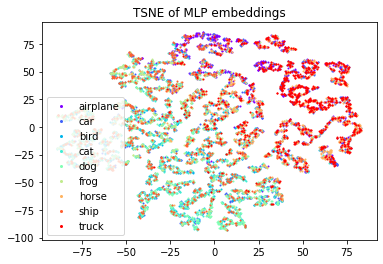

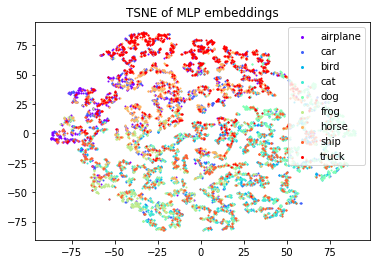

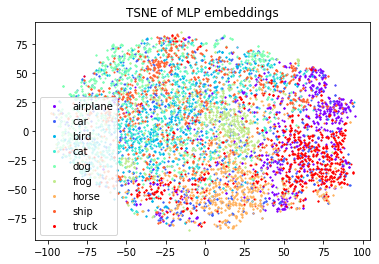

In [125]:
plot_tsne(feats2, labels2, pc=0)
plot_tsne(feats2, labels2, pc=2)
plot_tsne(feats2, labels2, pc=3)
plot_tsne(feats2, labels2, pc=10)

# MLP/CNN Filters Visualisation

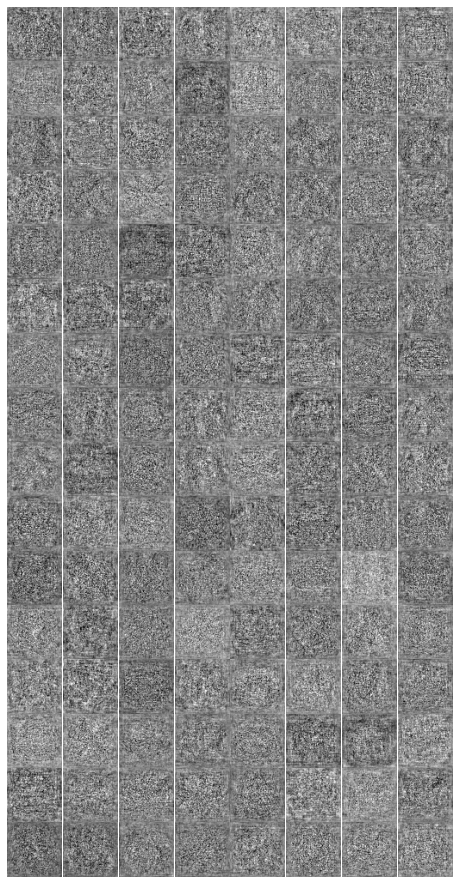

In [167]:
# fig, axs = plt.subplots(16, 32)
row, col = 16, 8
fig, ax = plt.subplots(row, col, figsize=(8,16))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model1.l1.weight.reshape((-1, 64, 64))[r*col + c, :, :].detach(), cmap='gray')
plt.show()

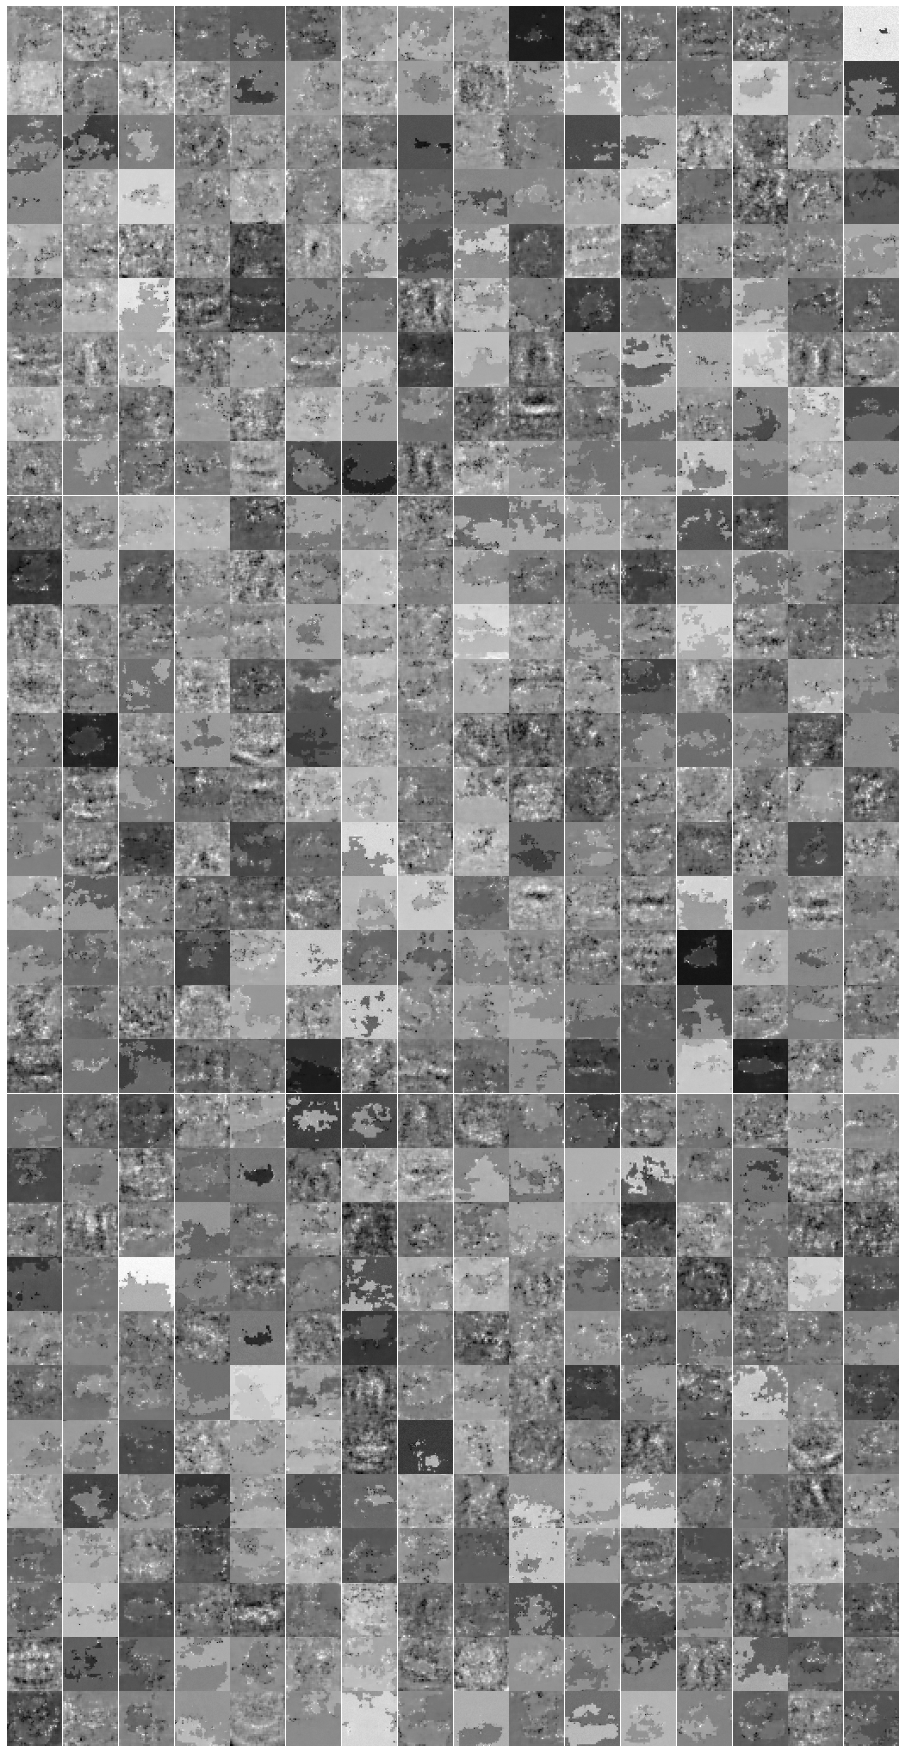

In [166]:
# fig, axs = plt.subplots(16, 32)
row, col = 32, 16
fig, ax = plt.subplots(row, col, figsize=(16,32))
plt.axis('off')
plt.subplots_adjust(hspace=0.001, wspace=0.001)
for r in range(row):
    for c in range(col):
        ax[r,c].axis('off')
        ax[r,c].set_xticks([])
        ax[r,c].set_yticks([])
        ax[r,c].imshow(model2.l1.weight.reshape((-1, 3, 64, 64))[r*col + c, 0, :, :].detach(), cmap='gray')
plt.show()

In [6]:
doodle_model = V2ConvNet(1, 9)
real_model = V2ConvNet(3, 9)

In [7]:
model1 = load_model_dic(doodle_model, "v2cnn_trained/24_model1.pt")
model2 = load_model_dic(real_model, "v2cnn_trained/24_model2.pt")

Model loaded: v2cnn_trained/24_model1.pt
Model loaded: v2cnn_trained/24_model2.pt


In [113]:
model_weights = []
conv_layers = []
model_children = list(model1.children())

In [55]:
cnn_idx = 0
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        cnn_idx += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    cnn_idx += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)

In [68]:
for weight, conv in zip(model_weights, conv_layers):
    print(f"{conv}\t{tuple(weight.shape)}")

Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))	(128, 1, 3, 3)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))	(128, 128, 3, 3)
Conv2d(128, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))	(192, 128, 3, 3)
Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1))	(192, 192, 3, 3)
Conv2d(192, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))	(256, 192, 3, 3)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))	(256, 256, 3, 3)
Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))	(512, 256, 3, 3)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))	(512, 512, 3, 3)


In [108]:
x_y = {
    128: (16, 8),
    192: (16, 12),
    256: (16, 16),
    512: (16, 32)
}

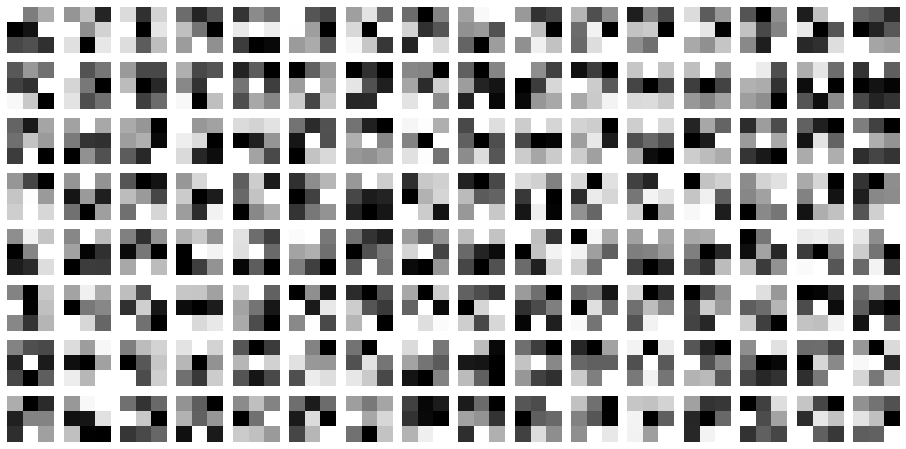

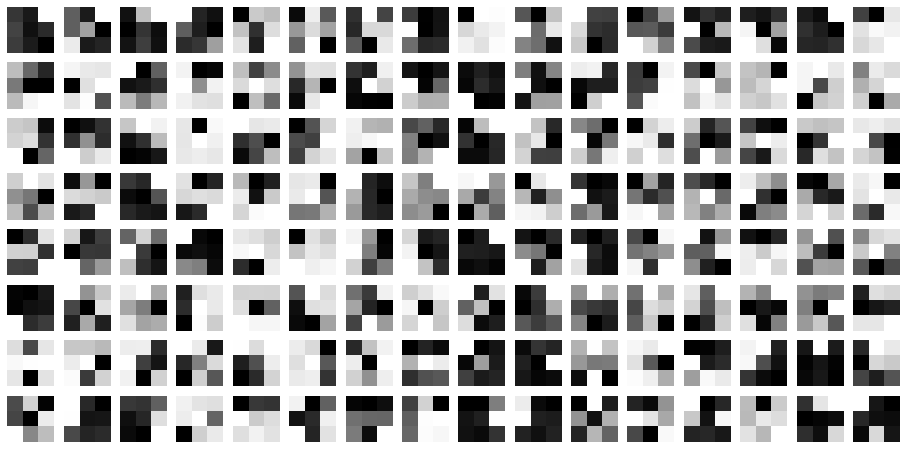

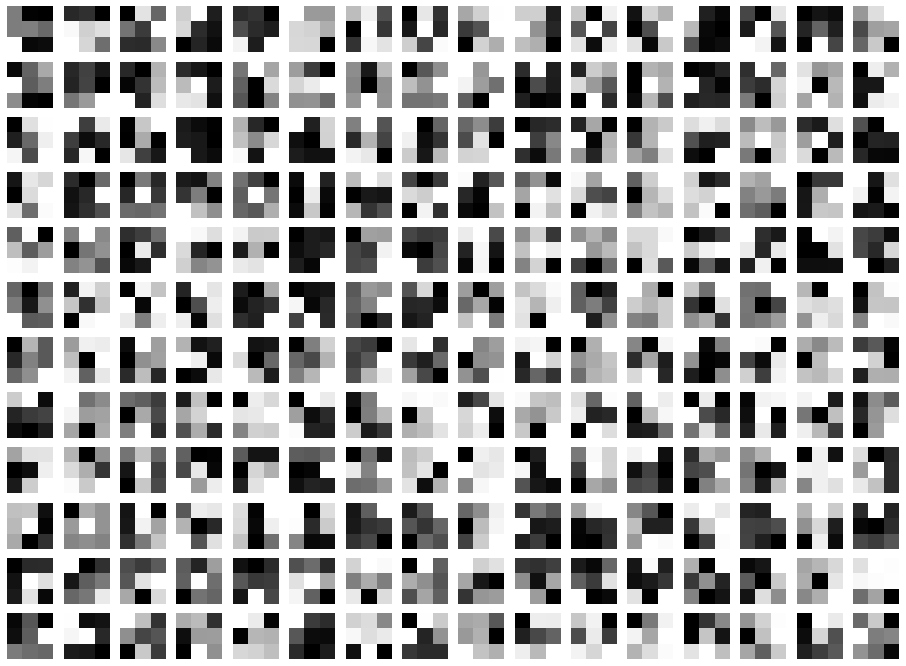

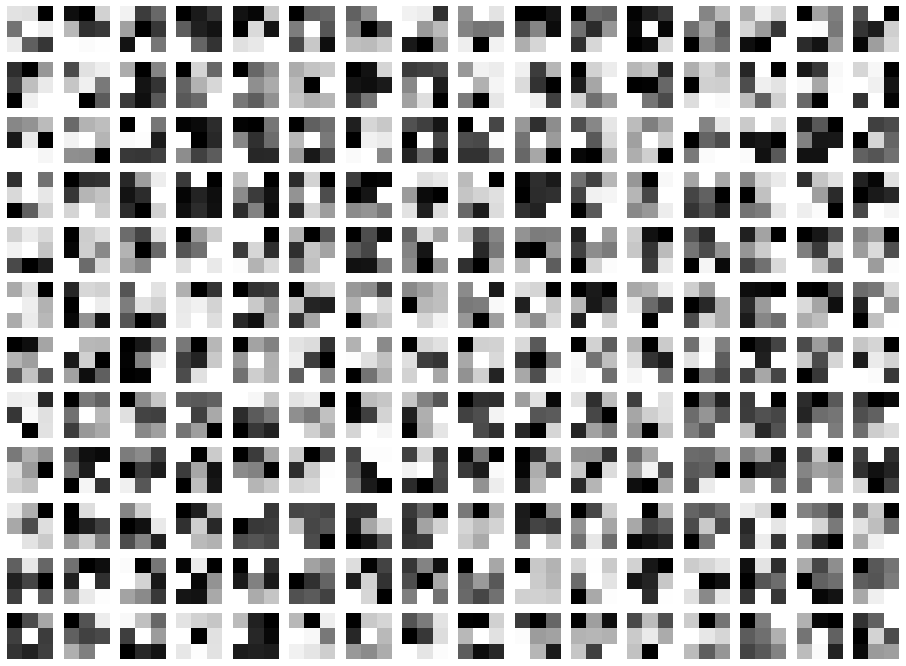

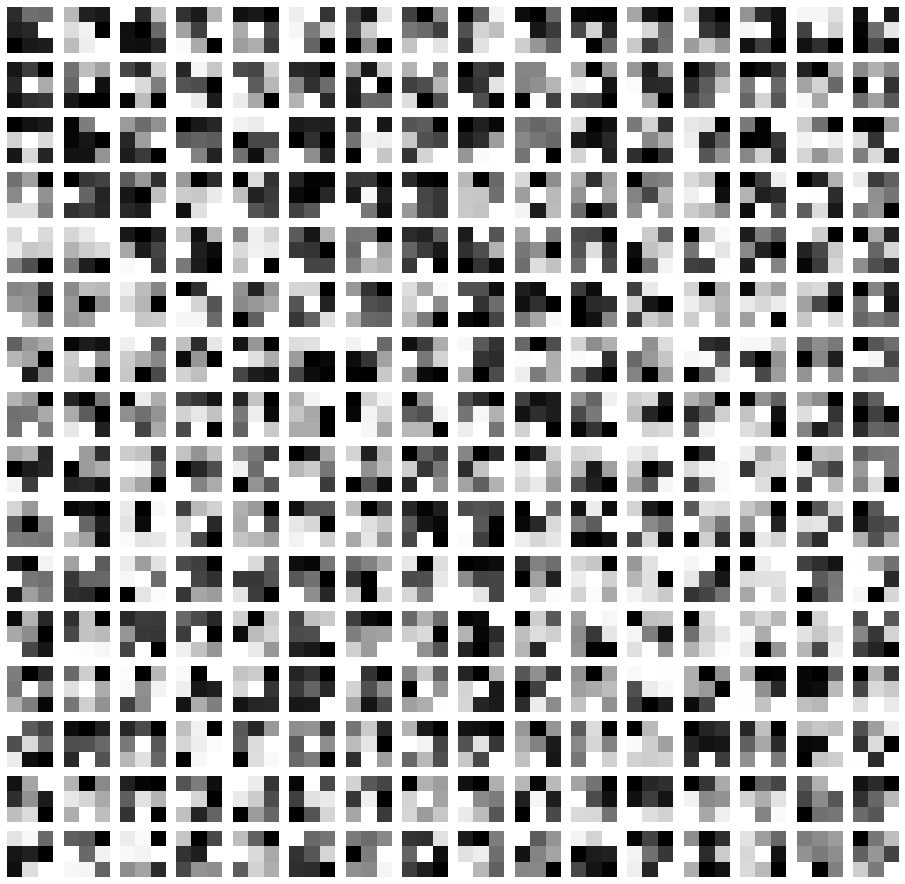

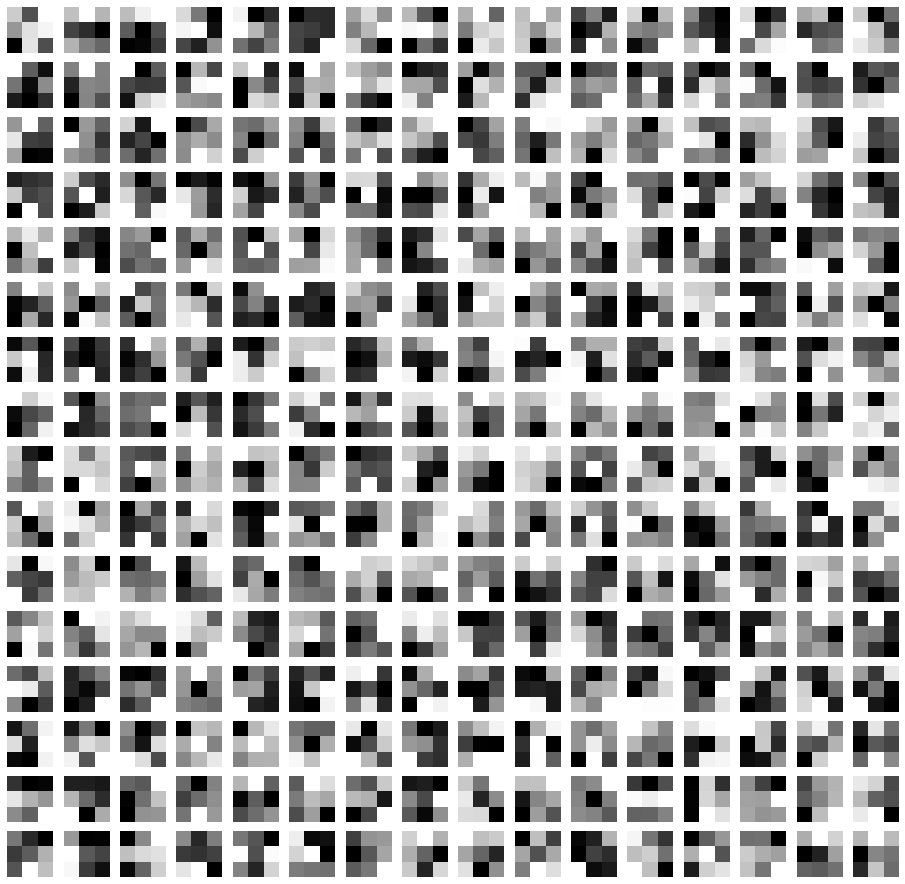

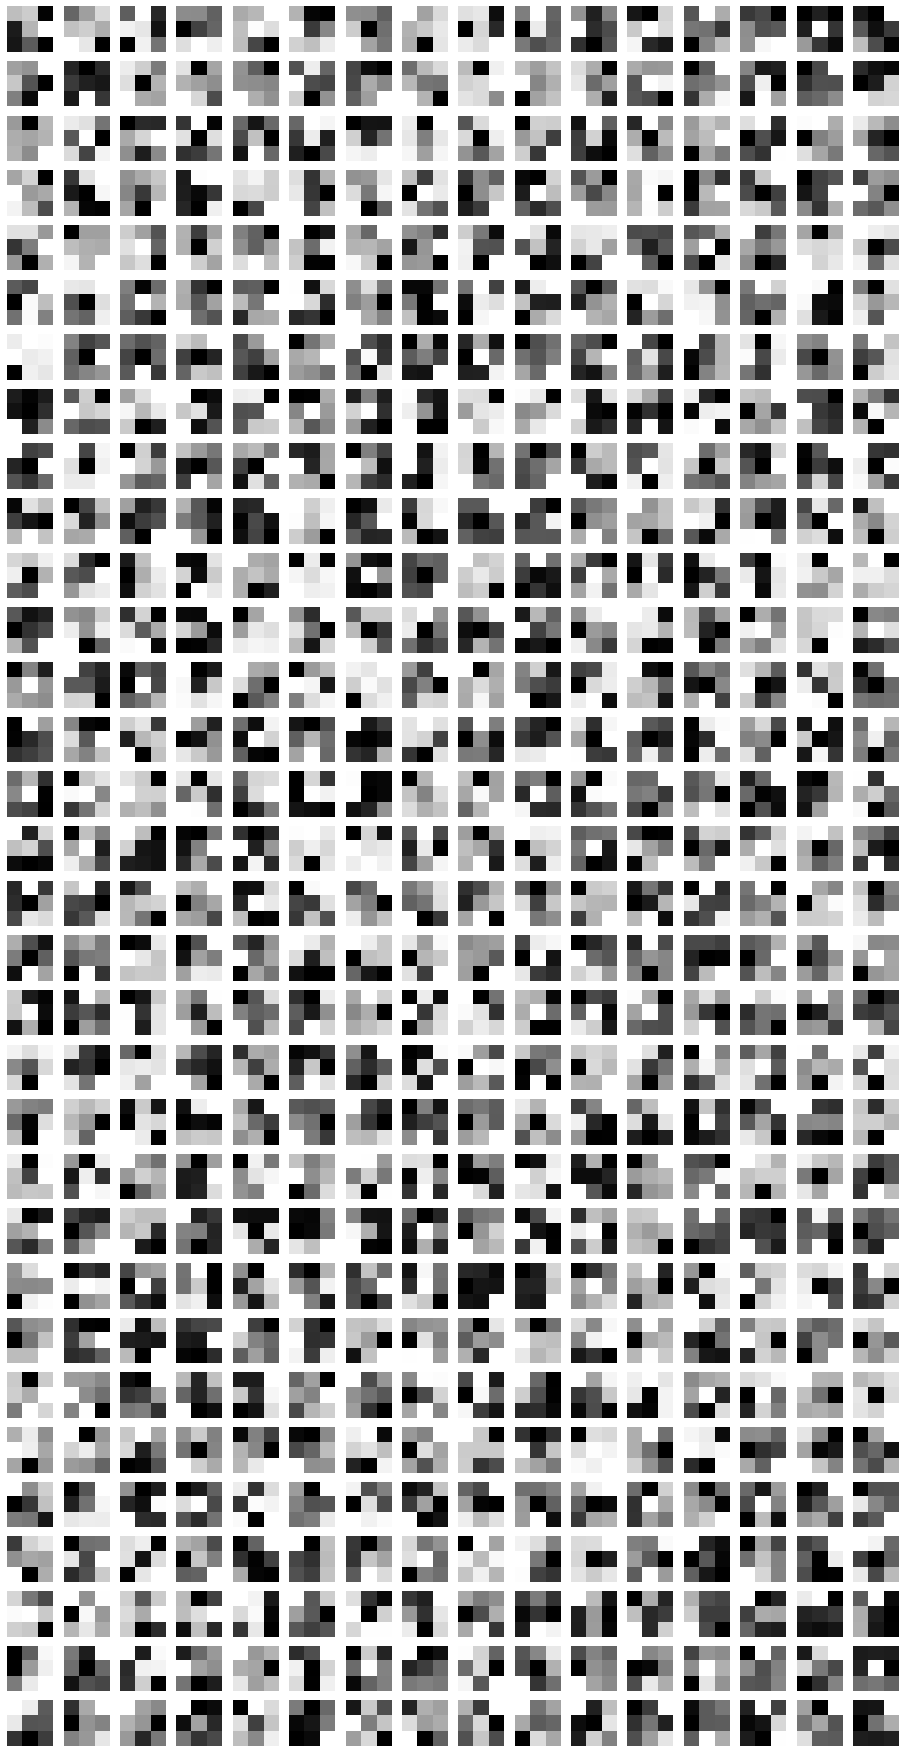

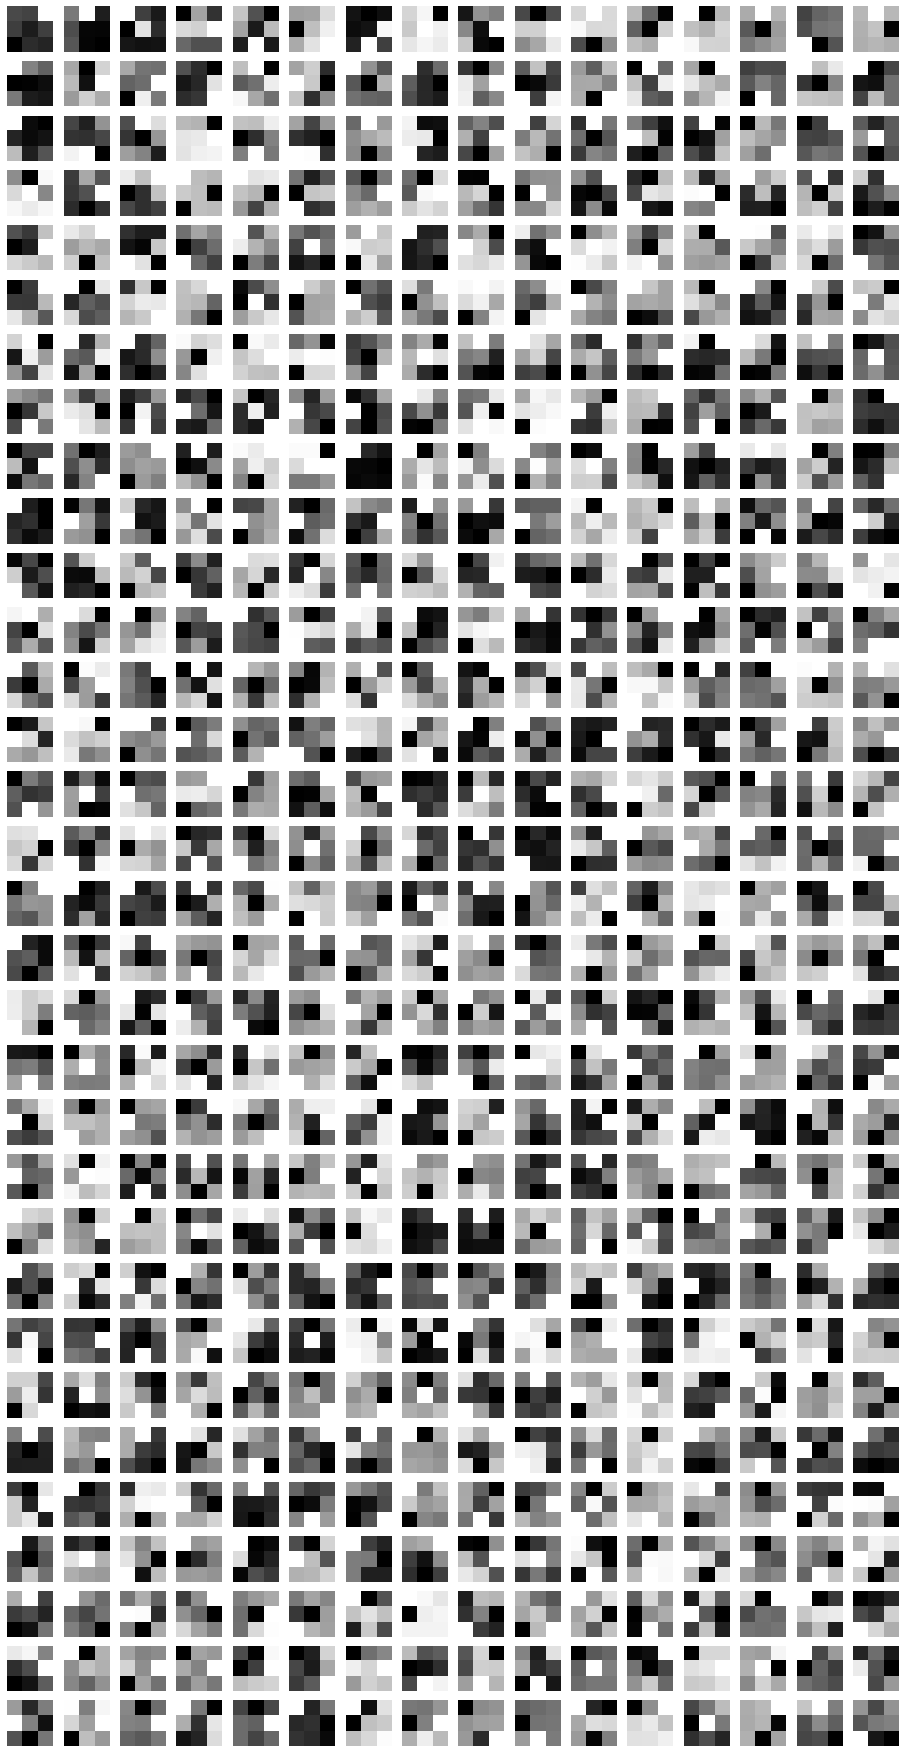

In [112]:
for c in range(len(model_weights)):
    x, y = x_y[model_weights[c].shape[0]]
    plt.figure(figsize=(x, y))
    for i, filter in enumerate(model_weights[c]):
        plt.subplot(y, x, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
        plt.imshow(filter[0, :, :].detach(), cmap='gray')
        plt.axis('off')
    plt.show()

# Sketchy Instance Pairs Similarity Evaluation

In [47]:
from dataset import *
class InstanceLevelEvaluator:
    def __init__(self):
        self.sketchy_pairs = np.load('dataset/sketchy_pairs.npy', allow_pickle=True)[()]
        print("== Sketchy dataset shapes ==")
        for i, d in sketchy_pairs.items():
            print(f"{i}: {d.shape}")
        DOODLES = ['sketchy_doodle', 'tuberlin', 'google_doodles']
        REAL = ['sketchy_real', 'google_real', 'cifar']
        train_dataset = ImageDataset(DOODLES, REAL, 64, 64, train=True)
        dt = train_dataset.doodle_preprocess
        rt = train_dataset.real_preprocess
        print("\nIMPT: Remove 'feats2[:,:128]' once features are same dim!!! (NOT DONE)")
    def evaluate(self, model1, model2):
        sims = []
        model1.eval()
        model2.eval()
        for i, d, r, c in zip(*self.get_sketchy()):
            pred1, feats1 = model1(dt(d), return_feats=True)
            pred2, feats2 = model2(torch.unsqueeze(rt(r), axis=0), return_feats=True)
            feats2 = feats2[:,:128]  # IMPT: Remove once features are same dim
            sim = F.cosine_similarity(feats1, feats2)
            sims.append(sim.item())
        sims = np.asarray(sims)
        return sims
    def get_sketchy(self):
        return (self.sketchy_pairs['idxs'],
                self.sketchy_pairs['doodles'],
                self.sketchy_pairs['reals'],
                self.sketchy_pairs['classes'])

In [48]:
evaluator = InstanceLevelEvaluator()

== Sketchy dataset shapes ==
idxs: (5829,)
doodles: (5829, 256, 256)
reals: (5829, 256, 256, 3)
classes: (5829,)
Train = True. Doodle list: ['sketchy_doodle', 'tuberlin', 'google_doodles'], 
 real list: ['sketchy_real', 'google_real', 'cifar']. 
 classes: dict_keys(['airplane', 'car', 'cat', 'dog', 'frog', 'horse', 'truck', 'bird', 'ship']) 
Doodle data size 7022, real data size 46364, ratio 0.15145371408851696

IMPT: Remove 'feats2[:,:128]' once features are same dim!!! (NOT DONE)


In [49]:
cosine_sims = evaluator.evaluate(model1, model2)
print(f"Avg sim: {cosine_sims.mean():.3f}")

Avg sim: 0.136
